#### imports environment config

In [1]:
import pandas as pd
import numpy as np
#import matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Import data and correct spelling of original column headers for consistency

In [6]:
df = pd.read_csv(r"C:\Users\shiva\Downloads\Fraud.csv" )



In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


###### Test if there any missing values in DataFrame. It turns out there are no obvious missing values but, as we will see below, this does not rule out proxies by a numerical value like 0.

In [9]:
df.isnull().values.any()

np.False_

### 2. Exploratory Data Analysis

### Which types of transactions are fraudulent?
 i find that of the five types of transactions, fraud occurs only in two of them 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs . These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. We will return to this issue later in section    

In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116

### What determines whether the feature isFlaggedFraud gets set or not?
   It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [11]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted [4]. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [12]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest= 0 and\
 newbalanceDes= 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest= 0 and newbalanceDes= 0: 4158


isFlaggedFraud being set cannot be thresholded on oldBalanceOrig since the corresponding range of values overlaps with that for TRANSFERs where isFlaggedFraud is not set (see below). Note that we do not need to consider newBalanceOrig since it is updated only after the transaction, whereas isFlaggedFraud would be set before the transaction takes place.

In [ ]:
print('\nMin, Max of oldbalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldbalanceOrg.min()), round(dfFlagged.oldbalanceOrg.max())]))

print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where \
oldbalanceOrg = 

In [ ]:
newbalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
== dfTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
               == dfTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldbalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where oldbalanceOrg = newbalanceOrig: [0.0, 575668]


Can isFlaggedFraud be set based on seeing a customer transacting more than once? Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [14]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


In [15]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


In [16]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [17]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


In [18]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [19]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [20]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values))


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


In [21]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [22]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldbalanceDest\' = \
\'newbalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldbalanceDest\' = \
newbalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldbalanceDest' = newbalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [23]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

In [24]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

In [25]:
print(dfTransfer.columns)


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [ ]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [27]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

In [28]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20)
plt.tight_layout()
plt.show()

TypeError: stripplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 4 keyword-only arguments) were given

<Figure size 1400x900 with 0 Axes>

In [ ]:
limit = len(X)
ax = plotStrip(X.type[:limit], X.amount[:limit], X.type[:limit], figsize=(14, 9))  # Swapped first two args
ax.set_ylabel('amount', size=16)
ax.set_title('Same-signed fingerprints of genuine and fraudulent transactions over amount', size=18)
plt.tight_layout()
plt.show()

In [31]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);
plt.tight_layout()
plt.show()

TypeError: stripplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 4 keyword-only arguments) were given

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


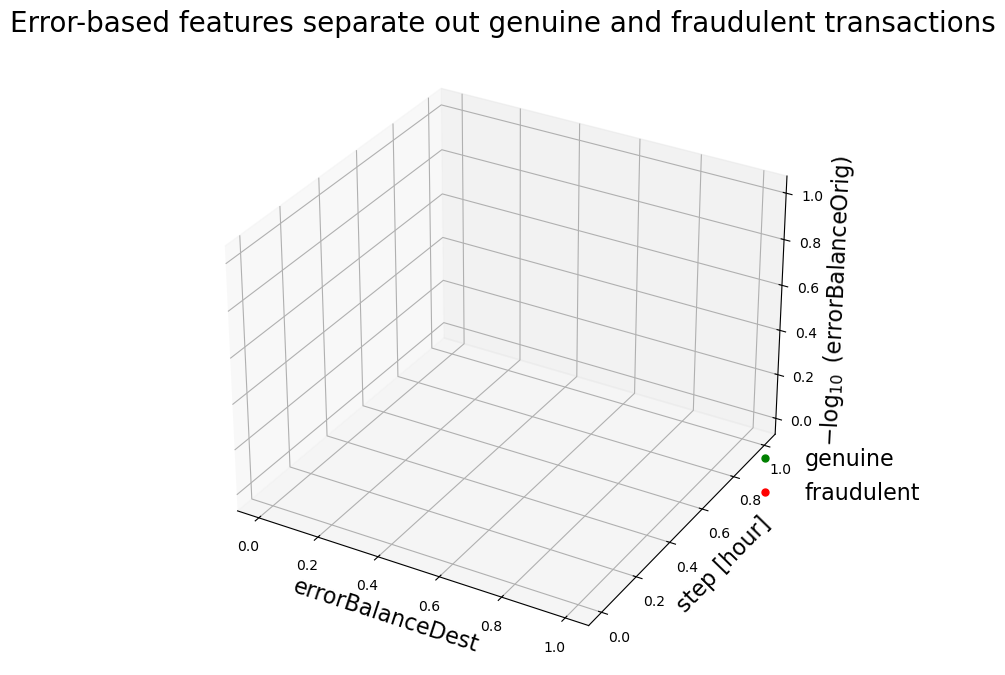

In [30]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig()  # Prevent Seaborn from overriding mplot3d defaults

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Genuine transactions (Y == 0)
genuine_mask = Y == 0
ax.scatter(X.loc[genuine_mask, x][:limit], X.loc[genuine_mask, y][:limit],
           -np.log10(X.loc[genuine_mask, z][:limit] + zOffset), c='g', marker='.',
           s=1, label='genuine', alpha=0.6)

# Fraudulent transactions (Y == 1)
fraud_mask = Y == 1
ax.scatter(X.loc[fraud_mask, x][:limit], X.loc[fraud_mask, y][:limit],
           -np.log10(X.loc[fraud_mask, z][:limit] + zOffset), c='r', marker='.',
           s=1, label='fraudulent', alpha=0.6)

ax.set_xlabel(x, size=16)
ax.set_ylabel(y + ' [hour]', size=16)
ax.set_zlabel(r'$-\log_{10}$ (' + z + ')', size=16)  # Raw string for clean LaTeX
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size=20)

# Tight bounds for 3D
ax.auto_scale_xyz([0, 1], [0, 1], [0, 1])  # Normalize to [0,1] then scale; adjust if needed
ax.grid(True)

# Custom legend markers
noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.',
                              markersize=10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.',
                            markersize=10, label='fraudulent')

# Place legend outside (adjust subplot for space)
plt.subplots_adjust(right=0.75)
ax.legend(handles=[noFraudMarker, fraudMarker],
          bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size': 16})

plt.show()

C:\Users\shiva\AppData\Local\Temp\ipykernel_14084\966174937.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


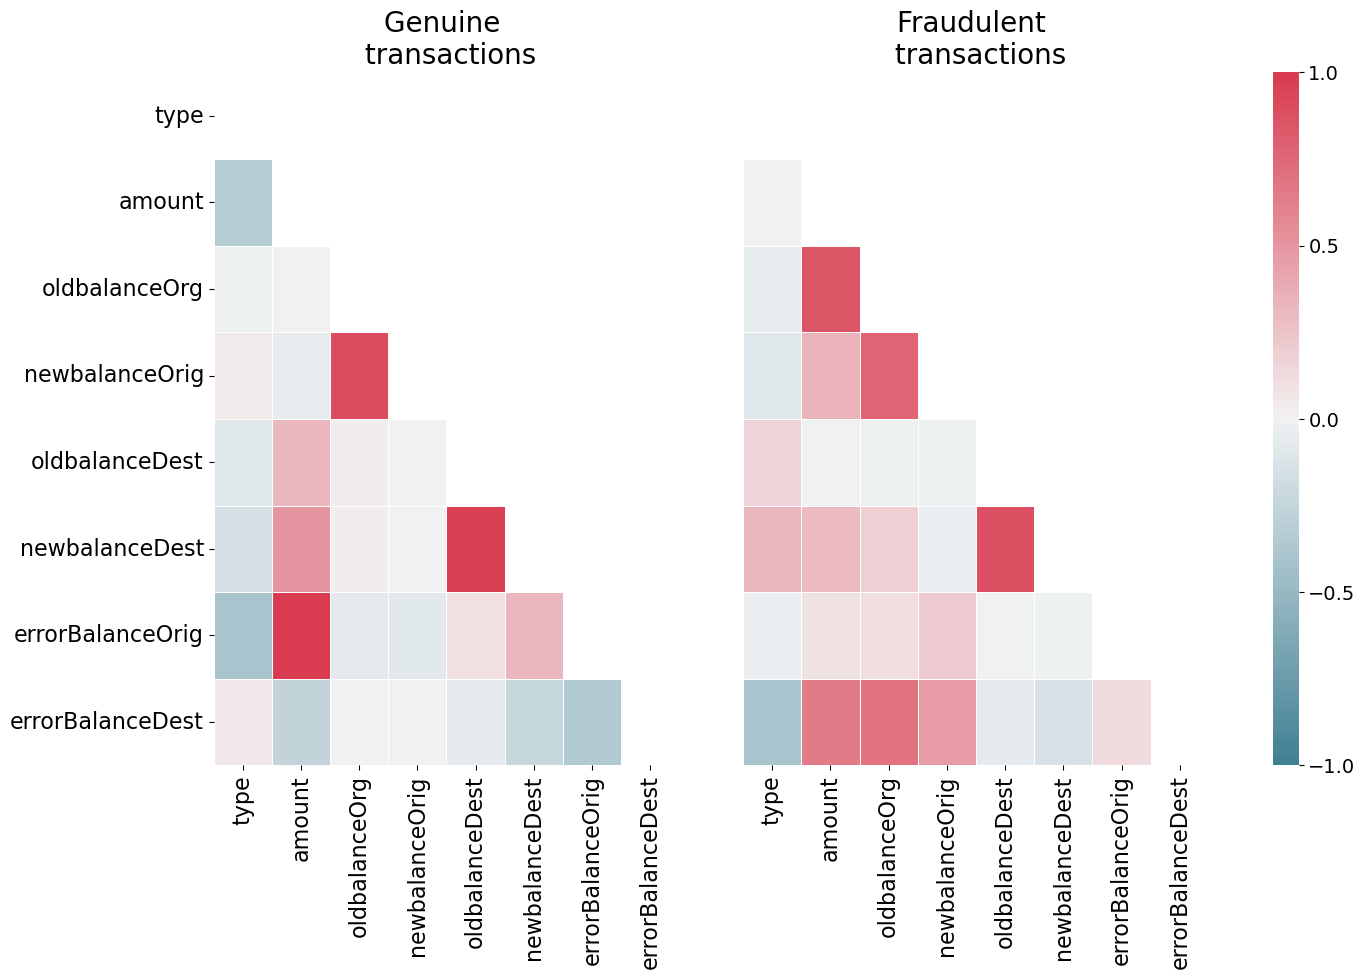

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and Y are already defined from prior cells

Xfraud = X.loc[Y == 1]  # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]

# Select columns excluding 'step'
feature_cols = X.columns[X.columns != 'step']

correlationNonFraud = XnonFraud[feature_cols].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, 
                                     figsize=(14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
sns.heatmap(correlationNonFraud, ax=ax1, vmin=-1, vmax=1, 
            cmap=cmap, square=False, linewidths=0.5, mask=mask, cbar=False)
ax1.set_title('Genuine \n transactions', size=20)

correlationFraud = Xfraud[feature_cols].corr()
sns.heatmap(correlationFraud, vmin=-1, vmax=1, cmap=cmap, 
            ax=ax2, square=False, linewidths=0.5, mask=mask, 
            yticklabels=False, cbar_ax=cbar_ax, 
            cbar_kws={'orientation': 'vertical', 
                      'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_title('Fraudulent \n transactions', size=20)

# Fixed: Use tick_params for font sizes (avoids TypeError on set_*icklabels with Text objects)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
cbar_ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [ ]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

## ver

In [ ]:

# Long computation (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())  # Class imbalance weight
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4, n_estimators=100)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [ ]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

In [ ]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);